# A Case for using Machine Learning Models to Improve Causal Inference in Economics

Randomized Controlled Trials (RCTs) are widely considered the gold standard for establishing causal relationships. While execution can be challenging, RCTs are valued for their straightforward methodology, ease of interpretation, and statistical robustness. However, RCTs are primarily evaluative, not prescriptive. They excel at determining a program's success and informing decisions about its continuation or implementation in similar contexts, but they don't make predictions. Furthermore, RCTs often overlook variations in treatment effects across subgroups. Let me demonstrate this with an example

### Import Libraries

In [1]:
import polars as pl
from scipy.stats import ttest_ind
import numpy as np
from sklearn.metrics import mean_squared_error

### Read the experiment dataset

In [2]:
df = pl.read_csv("dataset.csv")
df.head(10)

age,is_male,race,ownes_house,employment_status,employment_income,non_employment_income,treatment,expenditure
i64,i64,str,i64,i64,f64,f64,i64,f64
18,0,"""White""",0,0,0.0,0.0,0,2993.03
22,0,"""White""",1,1,71512.0,0.0,0,42829.0
18,1,"""White""",1,1,58287.6,9000.0,1,45194.99
18,0,"""White""",1,1,69786.9,0.0,0,51264.09
23,0,"""Other""",0,1,69507.0,0.0,0,49103.26
68,1,"""White""",0,1,232942.1,12000.0,0,168641.33
30,1,"""White""",1,1,92158.8,12000.0,0,67339.59
18,1,"""Asian""",0,1,62839.9,12000.0,0,40356.07
26,1,"""Black""",0,1,85679.5,12000.0,0,54805.69


The dataset contains information from a randomized controlled trial (RCT) designed to assess the impact of accidental and medical insurance on employment outcomes. It includes various demographic and background characteristics, such as age, education level, and prior work experience, alongside treatment assignment (whether an individual received medical insurance) and the outcome variable (employment status after the program). 

In this study, accidental and medical insurance was randomly assigned to 20% of the population, forming the treatment group, while the remaining individuals served as the control group without insurance benefits. The primary outcome of interest is the change in expenditure, measured as a continuous variable, with a focus on a one-tailed test to determine whether receiving insurance led to an increase in spending. Additionally, the analysis aims to explore potential differences in treatment effects across various subgroups to provide deeper insights into the program's effectiveness.

### Result of Randomized Controlled Trials (RCTs) in Expenditures 

In [3]:
treated = (df
.filter(pl.col('treatment') == 1)
.select('expenditure').to_numpy()
)

controlled = (df
.filter(pl.col('treatment') == 0)
.select('expenditure').to_numpy()
)


In [4]:
def p_test(treated, controlled):
    t_stat, p_val = ttest_ind(treated, controlled)
    # Store results in a dictionary
    results = {
        "Mean Expenditure (Treated)": treated.mean(),
        "Mean Expenditure (Controlled)": controlled.mean(),
        "T-statistic": t_stat[0],
        "P-value": p_val[0]
    }

    # Print readable output
    print("T-Test Results:")
    for key, value in results.items():
        print(f"{key}: {value:.4f}")

In [5]:
p_test(treated,controlled)

T-Test Results:
Mean Expenditure (Treated): 50544.4261
Mean Expenditure (Controlled): 44641.7624
T-statistic: 5.8597
P-value: 0.0000


The mean expenditure for the treatment group (those who received medical insurance) is 54,265.49, while the mean for the control group (those without insurance) is 47,629.78. The difference between the two groups is **6,635.71**. With a t-statistic of **13.41** and a p-value of less than **0.001**, this difference is statistically significant. 

These findings suggest that having accidental and medical insurance leads to increased spending. This implies that the security of a financial safety net encourages individuals to spend more, potentially stimulating economic activity and generating a multiplier effect throughout the economy.

### Factoring for different variable

#### Male

In [6]:
#Treatment and Control Impact by Gender
treated_male = df.filter(
    (pl.col('treatment') ==1) & (pl.col('is_male') == 1)
).select("expenditure").to_numpy()

controlled_male = df.filter(
    (pl.col('treatment')==0) & (pl.col('is_male')==1)
).select("expenditure").to_numpy()


In [7]:
p_test(treated_male, controlled_male)

T-Test Results:
Mean Expenditure (Treated): 51290.8735
Mean Expenditure (Controlled): 45066.2654
T-statistic: 4.6004
P-value: 0.0000


#### Female

In [8]:
#Treatment and Control Impact by Gender
treated_female = df.filter(
    (pl.col('treatment') ==1) & (pl.col('is_male') == 0)
).select("expenditure").to_numpy()

controlled_female = df.filter(
    (pl.col('treatment')==0) & (pl.col('is_male')==0)
).select("expenditure").to_numpy()

In [9]:
p_test(treated_female, controlled_female)

T-Test Results:
Mean Expenditure (Treated): 49585.8474
Mean Expenditure (Controlled): 44139.1981
T-statistic: 3.6084
P-value: 0.0003


To further analyze the impact of medical insurance, we examine its effects across gender subgroups. Our results indicate that both men and women experience a statistically significant increase in expenditure due to the treatment. However, the impact appears to be slightly greater for women than for men. 

This suggests that women may be more responsive to the financial security provided by insurance, potentially leading to higher spending. Understanding these gender-based differences can help policymakers design more targeted interventions to maximize the economic benefits of insurance programs.

### Employment Status

### On the employed

In [10]:
treated_employed = df.filter(
    (pl.col('treatment')==1) & (pl.col('employment_status')==1)
).select("expenditure").to_numpy()

controlled_employed = df.filter(
    (pl.col('treatment')==0) & (pl.col('employment_status')==1)
).select("expenditure").to_numpy()

In [11]:
p_test(treated_employed, controlled_employed)

T-Test Results:
Mean Expenditure (Treated): 82245.7384
Mean Expenditure (Controlled): 72026.3710
T-statistic: 10.2528
P-value: 0.0000


### On the unemployed

In [12]:
treated_unemployed = df.filter(
    (pl.col('treatment')==1) & (pl.col('employment_status')==0)
).select("expenditure").to_numpy()

controlled_unemployed = df.filter(
    (pl.col('treatment')==0) & (pl.col('employment_status')==0)
).select("expenditure").to_numpy()

In [13]:
p_test(treated_unemployed, controlled_unemployed)

T-Test Results:
Mean Expenditure (Treated): 6601.3125
Mean Expenditure (Controlled): 5984.1033
T-statistic: 3.8524
P-value: 0.0001


Another key subgroup of interest is employment status. Our results indicate that, regardless of whether an individual is employed or unemployed, the treatment effect leads to an increase in expenditure. However, unemployed individuals tend to spend less overall compared to their employed counterparts, and the increase in spending due to treatment is also more modest. 

This suggests that unemployed individuals may adopt a more cautious approach to spending, even when provided with financial security through insurance. These findings highlight the need for targeted strategies that consider economic behavior differences based on employment status, ensuring that support programs effectively address the needs of different groups.

## Having house or not

In [14]:
treated_house = df.filter(
    (pl.col('treatment')==1) & (pl.col('ownes_house')==1)
).select('expenditure').to_numpy()

controlled_house = df.filter(
    (pl.col('treatment')==0) & (pl.col('ownes_house')==1)
).select('expenditure').to_numpy()

In [15]:
p_test(treated_house, controlled_house)

T-Test Results:
Mean Expenditure (Treated): 50634.3989
Mean Expenditure (Controlled): 45308.7235
T-statistic: 2.9769
P-value: 0.0029


In [16]:
treated_rental = df.filter(
    (pl.col('treatment')==1) & (pl.col('ownes_house')==0)
).select('expenditure').to_numpy()

controlled_rental = df.filter(
    (pl.col('treatment')==0) & (pl.col('ownes_house')==0)
).select('expenditure').to_numpy()

In [17]:
p_test(treated_rental, controlled_rental)

T-Test Results:
Mean Expenditure (Treated): 50501.7356
Mean Expenditure (Controlled): 44360.5051
T-statistic: 5.0363
P-value: 0.0000


In [18]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Value')

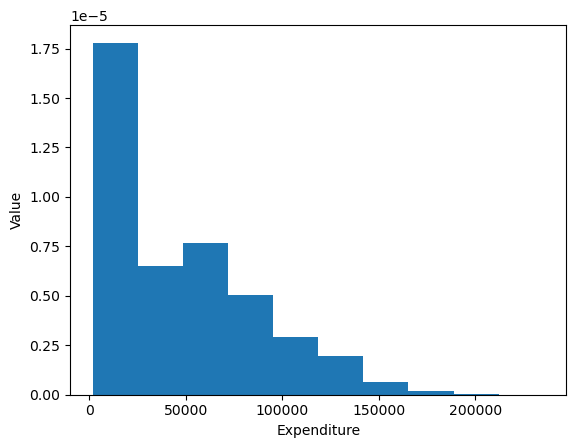

In [19]:
plt.hist(df['expenditure'], bins=10, density=True)
plt.xlabel('Expenditure')
plt.ylabel('Value')

Text(0.5, 1.0, 'Count of Treatment Groups')

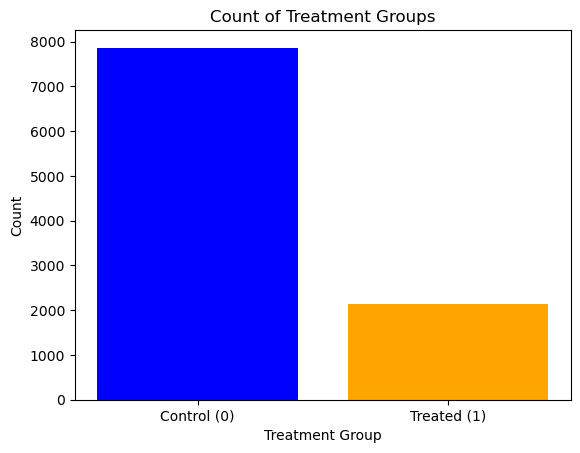

In [20]:
treatment_counts = df['treatment'].value_counts().sort('treatment')

# Convert Polars Series to lists for plotting
x = treatment_counts['treatment'].to_list()
y = treatment_counts['count'].to_list()

# Create bar plot
plt.bar(x, y, color=['blue', 'orange'])
plt.xlabel('Treatment Group')
plt.ylabel('Count')
plt.xticks([0, 1], ['Control (0)', 'Treated (1)'])  # Label the x-axis categories
plt.title('Count of Treatment Groups')


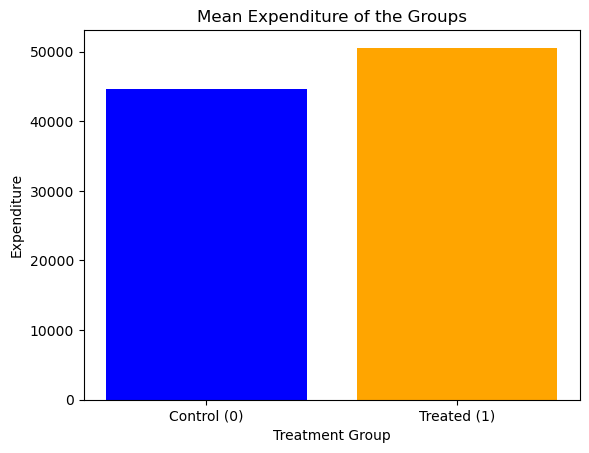

In [21]:
treatment_sums = df.group_by('treatment').agg(pl.col('expenditure').mean().alias('mean_expenditure'))
x = treatment_sums['treatment'].to_list()
y = treatment_sums['mean_expenditure'].to_list()

# Create bar plot
plt.bar(x, y, color=['blue', 'orange'])
plt.xlabel('Treatment Group')
plt.ylabel('Expenditure')
plt.xticks([0, 1], ['Control (0)', 'Treated (1)'])  # Label the x-axis categories
plt.title('Mean Expenditure of the Groups')
plt.show()

## Linear Model

Now that we have analyzed the RCT results, including overall treatment effects and subgroup differences, we turn to a linear regression model for a more comprehensive understanding of how various factors influence expenditure.  

Unlike simple mean comparisons between treatment and control groups, a linear regression model allows us to estimate the impact of multiple variables simultaneously. This approach provides a more precise measure of the treatment effect while accounting for potential confounding factors such as age, education level, previous work experience, and employment status. By incorporating all available variables, the model helps us isolate the true effect of medical insurance on expenditure and identify key determinants of spending behavior.  

This deeper analysis will provide a more nuanced understanding of how different factors interact, offering valuable insights for policymakers and stakeholders looking to design effective interventions.

In [22]:
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [23]:
race_array = df['race'].to_numpy()
label_encoder = LabelEncoder()
race_encoded = label_encoder.fit_transform(race_array)
df = df.with_columns(pl.Series('race_encoded', race_encoded))

In [24]:
df = df.drop('race')

In [25]:
lr = LinearRegression()

In [26]:
y = df['expenditure']#.to_numpy()
X = df.drop('expenditure')
feature_names = X.columns
#X = X.to_numpy()

In [27]:
import pyrsm as rsm

In [28]:
#using rsm
dfp = df.to_pandas()
rsm.model.regress({"df":dfp},rvar="expenditure",evar=feature_names).summary(rmse=True, ssq= True)

Linear regression (OLS)
Data                 : df
Response variable    : expenditure
Explanatory variables: age, is_male, ownes_house, employment_status, employment_income, non_employment_income, treatment, race_encoded
Null hyp.: the effect of x on expenditure is zero
Alt. hyp.: the effect of x on expenditure is not zero

                       coefficient  std.error  t.value p.value     
Intercept                 2990.342    252.885   11.825  < .001  ***
age                         -2.750      7.933   -0.347   0.729     
is_male                   -143.619    121.046   -1.186   0.235     
ownes_house                 20.375    131.259    0.155   0.877     
employment_status        -5055.385    320.512  -15.773  < .001  ***
employment_income            0.719      0.004  204.953  < .001  ***
non_employment_income        0.448      0.012   37.963  < .001  ***
treatment                 6158.661    146.988   41.899  < .001  ***
race_encoded               -14.245     39.358   -0.362   0.717 

The results of the linear regression model confirm that treatment is a highly significant factor in estimating expenditure. The treatment coefficient is **6,783.3**, making it the largest coefficient estimate among all variables, further reinforcing the strong impact of medical insurance on spending.  

In addition to treatment, **non-employment income, employment income, employment status, and age** are also significant predictors of expenditure, indicating that financial resources and labor market participation play crucial roles in spending behavior.  

While **gender** has a p-value of **0.09**, meaning it is not statistically significant at the conventional **5% level**, it is still close enough to warrant further exploration. This suggests there may be meaningful gender differences in how individuals respond to medical insurance, which could be better understood through additional analysis or interaction effects in the model.

### Let's see how the regression result would have been in absence of any treatment

In [29]:
# since treatment may absorb all the information, let's see without treatment
X_noTreat = df.drop('expenditure','treatment')
feature_names_noTreat = X_noTreat.columns

In [30]:
rsm.model.regress({"df all":dfp},rvar="expenditure",evar=feature_names_noTreat).summary(rmse=True, ssq= True)

Linear regression (OLS)
Data                 : df all
Response variable    : expenditure
Explanatory variables: age, is_male, ownes_house, employment_status, employment_income, non_employment_income, race_encoded
Null hyp.: the effect of x on expenditure is zero
Alt. hyp.: the effect of x on expenditure is not zero

                       coefficient  std.error  t.value p.value     
Intercept                 4182.208    272.449   15.350  < .001  ***
age                          0.517      8.601    0.060   0.952     
is_male                    -60.457    131.226   -0.461   0.645     
ownes_house                142.570    142.282    1.002   0.316     
employment_status        -4984.357    347.510  -14.343  < .001  ***
employment_income            0.718      0.004  188.718  < .001  ***
non_employment_income        0.450      0.013   35.118  < .001  ***
race_encoded               -27.931     42.672   -0.655   0.513     

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-squ

By removing the **treatment** variable from the regression model, we aim to examine the underlying conditions before treatment or in its absence. This allows us to understand the natural relationships between other predictors and expenditure.  

Without the treatment variable, the coefficients of all predictors have adjusted, yet the same variables remain significant while others do not. Notably, **gender (is_male)** now has a lower p-value of **0.065**, making it even closer to statistical significance at the 5% level. This suggests that gender may have a more pronounced influence on expenditure than previously detected, and further investigation could help clarify its role.  

This analysis provides a clearer baseline for understanding spending patterns without the influence of medical insurance, offering valuable insights into pre-existing economic behaviors.

## Only treated people vs Not Treated people

### Let's see how the regression result would have been if all were treatment

In [31]:
df_treated = df.filter(pl.col('treatment')==1).drop('treatment')
df_controled = df.filter(pl.col('treatment')==0).drop('treatment')

In [32]:
dft = df_treated.to_pandas()
rsm.model.regress({"df treated":dft},rvar="expenditure",evar=feature_names_noTreat).summary(rmse=True, ssq= True)

Linear regression (OLS)
Data                 : df treated
Response variable    : expenditure
Explanatory variables: age, is_male, ownes_house, employment_status, employment_income, non_employment_income, race_encoded
Null hyp.: the effect of x on expenditure is zero
Alt. hyp.: the effect of x on expenditure is not zero

                       coefficient  std.error  t.value p.value     
Intercept                 4220.726    735.595    5.738  < .001  ***
age                          5.364     22.196    0.242   0.809     
is_male                      9.500    367.900    0.026   0.979     
ownes_house               -225.473    390.682   -0.577   0.564     
employment_status        -4450.097    933.202   -4.769  < .001  ***
employment_income            0.787      0.010   79.140  < .001  ***
non_employment_income        0.445      0.036   12.392  < .001  ***
race_encoded               132.419    120.057    1.103    0.27     

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R

In [33]:
dfc = df_controled.to_pandas()
rsm.model.regress({"df controled":dfc},rvar="expenditure",evar=feature_names_noTreat).summary(rmse=True, ssq= True)

Linear regression (OLS)
Data                 : df controled
Response variable    : expenditure
Explanatory variables: age, is_male, ownes_house, employment_status, employment_income, non_employment_income, race_encoded
Null hyp.: the effect of x on expenditure is zero
Alt. hyp.: the effect of x on expenditure is not zero

                       coefficient  std.error  t.value p.value     
Intercept                 4125.860    213.482   19.326  < .001  ***
age                          3.186      6.827    0.467   0.641     
is_male                   -191.834    101.570   -1.889   0.059    .
ownes_house                108.226    110.777    0.977   0.329     
employment_status        -4890.693    272.596  -17.941  < .001  ***
employment_income            0.697      0.003  231.600  < .001  ***
non_employment_income        0.449      0.010   45.295  < .001  ***
race_encoded               -47.014     33.002   -1.425   0.154     

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In an alternative scenario where **everyone receives treatment**, we run the regression exclusively on the treated group. The results largely mirror previous findings, with the same significant variables, except for two key differences:  

1. **Gender (is_male) becomes statistically significant** with a p-value of **0.047**, indicating that male participants tend to spend **$363 less** than females. This suggests that the impact of treatment is stronger for women, reinforcing the idea that medical insurance may influence female spending behavior more than male spending.  

2. **Age is no longer significant**, with a p-value of **0.6**, meaning that once everyone is treated, age does not appear to play a role in determining expenditure. This contrasts with previous models where age was a significant predictor, implying that treatment standardizes spending behavior across different age groups.  

These findings highlight that **gender differences in spending become more pronounced with treatment**, while age loses its predictive power when medical insurance is universally provided. This insight could be valuable for designing policies that maximize the economic impact of insurance programs.

## Now, let us run the estimate

Now, I will run the regression model by dividing the data into training and test sets. This will allow me to calculate the mean squared error (MSE) between the training and test sets. Our goal is to make a forecast: if the insurance benefit were to be scaled up, we want to estimate how impactful it would be. By using this approach, we can assess the effectiveness of the program and predict its potential outcomes.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=99)

In [35]:
reg = lr.fit(X_train,y_train)

In [36]:
# Get feature names and coefficients
{'Intercept': reg.intercept_, 
              **{feature_names[i]: reg.coef_[i] for i in range(len(feature_names))}}



{'Intercept': 3030.285988660842,
 'age': -3.458385404797223,
 'is_male': -25.387760242458356,
 'ownes_house': -83.83388851503886,
 'employment_status': -5114.66236932114,
 'employment_income': 0.7203499134540611,
 'non_employment_income': 0.44206800625092707,
 'treatment': 6154.736048316374,
 'race_encoded': -31.75624500157307}

The values are slightly different since the training set is not different from the full set that I used before

In [37]:
predicted_expenditure = reg.predict(X_test)

In [38]:
predicted_expenditure

array([ 12925.94078028, 107303.17114043,   2764.92559246, ...,
         8913.45813664,   6857.74685739,  51127.29725327])

In [39]:
result = X_test.with_columns(
    pl.Series(y_test).alias('actual_expenditure'),
    pl.Series(predicted_expenditure).alias('pred_expenditure')
    
)
result

age,is_male,ownes_house,employment_status,employment_income,non_employment_income,treatment,race_encoded,actual_expenditure,pred_expenditure
i64,i64,i64,i64,f64,f64,i64,i32,f64,f64
32,0,0,0,0.0,9000.0,1,4,8435.84,12925.94078
55,0,1,1,145045.9,12000.0,0,4,109527.42,107303.17114
40,0,0,0,0.0,0.0,0,4,2551.92,2764.925592
22,0,0,1,70114.7,1000.0,0,4,53285.6,48661.700244
21,0,0,1,62536.3,9000.0,0,2,43791.63,46806.115385
…,…,…,…,…,…,…,…,…,…
26,1,0,1,81198.2,0.0,0,4,53962.76,56164.409201
33,1,0,1,104481.1,12000.0,0,0,87443.79,78343.876558
62,1,0,0,0.0,0.0,1,1,3193.81,8913.458137


The root mean square error between actual expenditure and predicted expenditure

In [40]:
mse = mean_squared_error(y_test, predicted_expenditure)
rmse = mse ** 0.5
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 34059413.35434576
Root Mean Squared Error: 5836.044324227307


An RMSE of 6553.5 means that, on average, the model's predictions are off by 6553.5. But how good or bad is that? Looking back at some of the model's outputs, we realized that the mean differences for particular subgroups were around 5000 to 10,000. Is an RMSE of 6553.5 a concern? Let me calculate the RMSE percentage, which should provide a clearer picture of our errors.

In [41]:
mean_actual = result["actual_expenditure"].mean()
mean_actual

45762.165704

In [42]:
rmse_percentage = (rmse / mean_actual) * 100
print(f"RMSE as % of Mean Expenditure: {rmse_percentage:.2f}%")

RMSE as % of Mean Expenditure: 12.75%


The RMSE is 13.4%. In most cases, a small RMSE percentage is considered a sign of good model performance. A score of less than 20% is generally regarded as good. Based on this, we can say that our model is performing well.

### Now what?
Now that we know the model can make good predictions, what should we do next? Should the insurance be targeted to all individuals, since the RCT showed positive results? If we target everyone, then what role does the linear regression model play? Alternatively, should we focus on targeting individuals with the highest expenditures? Or perhaps we should target those with the largest difference in expenditures, i.e., the gap between their actual and predicted expenditures. However, there is an issue: the people who were treated will naturally have a larger difference compared to the control group, as we observed in our regression model. Let me verify this further.

In [43]:
result = result.with_columns(
    (pl.col("actual_expenditure") - pl.col("pred_expenditure")).alias("difference")
)

mean_diff_treated = (result
    .filter(pl.col("treatment") == 1)
    .select(pl.col("difference")).mean()
).to_numpy()[0][0]

# Calculate the mean difference for control group (treatment == 0)
mean_diff_control = (result
    .filter(pl.col("treatment") == 0)
    .select(pl.col("difference")).mean()
).to_numpy()[0][0]

# Print both mean differences side by side
print(f"Mean Difference for Treated Group: {mean_diff_treated}, Mean Difference for Control Group: {mean_diff_control}")

Mean Difference for Treated Group: 8.172042775353619, Mean Difference for Control Group: -8.313226655199559


While we’ve addressed the policy question of whether the treatment is effective or not, we still can't determine the best way to move forward. Sure, we could target everyone, but that could be costly and inefficient. Using a linear model, we could focus on individuals with the largest difference in expenditure, based on the features we used to build the model. However, we’ve observed that being treated is a significant factor, and it's the feature that impacts expenditure the most. So, how can we identify which individuals benefit the most from this program?

This is where Meta-Learners can help.

# Using Meta Learners to make prediction

Now, the main goal of a meta-learner is to differentiate how people’s expenditures would change if they were treated versus if they were not treated. You may recall how we built a few linear models earlier, one where we kept 'treated' as a variable, and others where we didn’t include it as a variable, instead filtering treated and control groups separately. These concepts will be used in the Meta Learner.

I wil be taking about one kind of Meta Learner today, that is T-Learner.

1. T-Learner:
The T-Learner, on the other hand, fits two separate models: one for the treated group and one for the control group. Each model predicts the outcome based on its respective group, and the difference in outcomes between the two models for an individual is used to estimate the individual treatment effect (ITE). The T-Learner allows for heterogeneous treatment effects, meaning it can capture the fact that different people may experience different effects from the treatment, making it a more flexible approach than the S-Learner when treatment effects vary across individuals.

By using these meta-learners, we can more accurately estimate who benefits the most from the treatment, allowing us to target individuals who will likely see the greatest improvement in expenditure from receiving the treatment.

Now, prediction is where it gets different. I will not be using the treatment variable in the same way for making the prediction. Instead, I will make two separate predictions using the T-Learner approach.

In the T-Learner, we train two separate models: one for the treated group and another for the control group. This allows each model to independently learn the relationship between the features and the outcome for both treated and control individuals. Afterward, I will predict the outcome for each individual as if they were in both the treated and control groups.

Here’s how I approach this:

Train Two Models:

Model 1: Train a model using the data for the treated group (where treatment = 1).

Model 2: Train another model using the data for the control group (where treatment = 0).

Make Predictions:

Prediction 1: Use Model 1 (treated group) to predict the outcome as if everyone received the treatment.

Prediction 2: Use Model 2 (control group) to predict the outcome as if no one received the treatment.

Calculate the Difference:

By comparing the predicted outcomes for the treated and control groups, we can find the difference in predicted expenditure for each individual.

The individuals who show the highest difference between the treated and control predictions are likely to benefit the most from the treatment. For example, individuals with higher predicted outcomes in the treated group compared to the control group would be the ones who see the largest benefit from the insurance treatment.

In this way, the T-Learner allows us to estimate the individualized treatment effect by predicting how each person would behave in both treatment and control conditions, and then comparing those predictions.

For instance, being a woman, unemployed, and older might result in the most benefit from the treatment. The difference between the two predictions should be the highest for such a person (just an example)

In [44]:
X_treated = df.filter(pl.col('treatment')==1).drop('expenditure','treatment')
X_control = df.filter(pl.col('treatment')==0).drop('expenditure','treatment')

y_treated = df.filter(pl.col('treatment')==1).select('expenditure').to_numpy()
y_control = df.filter(pl.col('treatment')==0).select('expenditure').to_numpy()


In [45]:
print(y_treated.mean(), y_control.mean())

50544.42614125351 44641.76244085474


In [46]:
lr= LinearRegression()
lr_treated = lr.fit(X_treated.to_numpy(),y_treated)
lr= LinearRegression()
lr_control = lr.fit(X_control.to_numpy(),y_control)


In [47]:
predicted_expenditure_treated = lr_treated.predict(df.drop('expenditure','treatment'))
predicted_expenditure_control = lr_control.predict(df.drop('expenditure','treatment'))

c:\Users\meala\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\meala\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [48]:
df = df.with_columns(
    pl.Series(predicted_expenditure_treated.flatten()).alias('predicted_expenditure_treated'),
    pl.Series(predicted_expenditure_control.flatten()).alias('predicted_expenditure_control')
)

In [49]:
df.head(10)

age,is_male,ownes_house,employment_status,employment_income,non_employment_income,treatment,expenditure,race_encoded,predicted_expenditure_treated,predicted_expenditure_control
i64,i64,i64,i64,f64,f64,i64,f64,i32,f64,f64
18,0,0,0,0.0,0.0,0,2993.03,4,4846.948558,3995.160217
22,0,1,1,71512.0,0.0,0,42829.0,4,56487.114917,49068.766969
18,1,1,1,58287.6,9000.0,1,45194.99,4,50069.511648,43685.418864
18,0,1,1,69786.9,0.0,0,51264.09,4,55107.660217,47853.639374
23,0,0,1,69507.0,0.0,0,49103.26,3,55007.196499,47613.271204
68,1,0,1,232942.1,12000.0,0,168641.33,4,189386.150184,166815.573042
30,1,1,1,92158.8,12000.0,0,67339.59,4,78132.170784,68677.80883
18,1,0,1,62839.9,12000.0,0,40356.07,0,54683.752227,48284.347323
26,1,0,1,85679.5,12000.0,0,54805.69,1,72838.425263,64181.855078


In [50]:
df= df.with_columns(
    (pl.col('predicted_expenditure_treated') - pl.col('predicted_expenditure_control')).alias('difference')
)
df.head(5)

age,is_male,ownes_house,employment_status,employment_income,non_employment_income,treatment,expenditure,race_encoded,predicted_expenditure_treated,predicted_expenditure_control,difference
i64,i64,i64,i64,f64,f64,i64,f64,i32,f64,f64,f64
18,0,0,0,0.0,0.0,0,2993.03,4,4846.948558,3995.160217,851.788341
22,0,1,1,71512.0,0.0,0,42829.0,4,56487.114917,49068.766969,7418.347948
18,1,1,1,58287.6,9000.0,1,45194.99,4,50069.511648,43685.418864,6384.092785
18,0,1,1,69786.9,0.0,0,51264.09,4,55107.660217,47853.639374,7254.020843
23,0,0,1,69507.0,0.0,0,49103.26,3,55007.196499,47613.271204,7393.925295


In [51]:
df = df.with_columns(
    (pl.col("difference").rank("dense") * 10 / len(df))  # Scale ranks to 0-10
    .ceil()  # Round up to 1-10
    .clip(1, 10)  # Ensure no overflow
    .cast(pl.UInt8)  # Save memory
    .alias("decile")
)
df.head(10)


age,is_male,ownes_house,employment_status,employment_income,non_employment_income,treatment,expenditure,race_encoded,predicted_expenditure_treated,predicted_expenditure_control,difference,decile
i64,i64,i64,i64,f64,f64,i64,f64,i32,f64,f64,f64,u8
18,0,0,0,0.0,0.0,0,2993.03,4,4846.948558,3995.160217,851.788341,1
22,0,1,1,71512.0,0.0,0,42829.0,4,56487.114917,49068.766969,7418.347948,4
18,1,1,1,58287.6,9000.0,1,45194.99,4,50069.511648,43685.418864,6384.092785,2
18,0,1,1,69786.9,0.0,0,51264.09,4,55107.660217,47853.639374,7254.020843,4
23,0,0,1,69507.0,0.0,0,49103.26,3,55007.196499,47613.271204,7393.925295,4
68,1,0,1,232942.1,12000.0,0,168641.33,4,189386.150184,166815.573042,22570.577142,8
30,1,1,1,92158.8,12000.0,0,67339.59,4,78132.170784,68677.80883,9454.361954,5
18,1,0,1,62839.9,12000.0,0,40356.07,0,54683.752227,48284.347323,6399.404905,2
26,1,0,1,85679.5,12000.0,0,54805.69,1,72838.425263,64181.855078,8656.570185,4


## How to do new treatment?
Now that we have the predictions, we can use them to determine how to treat individuals. I have a new dataset of almost similar feature. The total population in this new dataset is 10,000 individuals. Say I have enough budget for treatment for 2,500 individuals. 

Randomized Conterolled Trial (RCT)  established that the treatment is effective. However, should we be randomly treating the 2,500 individual or should we be treating the individuals who are likely to benefit the most from the treatment?

Let see how effective the treatment would be if we randomly treat 2,500 individuals vs targetted treatment of 2,500 individuals.

## Viewing the data and randomly assigning treatment

In [53]:
target_df = pl.read_csv("new_target.csv")
target_df.head(10)

age,is_male,race,ownes_house,employment_status,employment_income,non_employment_income
i64,i64,str,i64,i64,f64,f64
18,0,"""White""",0,0,0.0,0.0
22,0,"""White""",1,1,71512.0,0.0
18,1,"""White""",1,1,58287.6,9000.0
18,0,"""White""",1,1,69786.9,0.0
23,0,"""Other""",0,1,69507.0,0.0
68,1,"""White""",0,1,232942.1,12000.0
30,1,"""White""",1,1,92158.8,12000.0
18,1,"""Asian""",0,1,62839.9,12000.0
26,1,"""Black""",0,1,85679.5,12000.0


## Randomly assigning treatment


In [54]:
np.random.seed(259)

In [56]:
treatment = np.random.choice([1, 0], target_df.shape[0], p=[0.2, 0.8])
target = target_df.with_columns(
    pl.Series("treatment", treatment)
)
target.head(10)

age,is_male,race,ownes_house,employment_status,employment_income,non_employment_income,treatment
i64,i64,str,i64,i64,f64,f64,i32
18,0,"""White""",0,0,0.0,0.0,0
22,0,"""White""",1,1,71512.0,0.0,1
18,1,"""White""",1,1,58287.6,9000.0,0
18,0,"""White""",1,1,69786.9,0.0,0
23,0,"""Other""",0,1,69507.0,0.0,0
68,1,"""White""",0,1,232942.1,12000.0,0
30,1,"""White""",1,1,92158.8,12000.0,0
18,1,"""Asian""",0,1,62839.9,12000.0,0
26,1,"""Black""",0,1,85679.5,12000.0,0


The function below simulates the expenditure of the population. Note, that this simulation is based on very similary features as the original dataset. The treatment is randomly assigned to 2,500 individuals, and the expenditure is calculated based on the treatment assignment.
With random individual getting treatment, let us impact of treatment on expenditure for the treated group and the whole population

In [57]:
%run data_processor.ipynb  # Executes the notebook
# Then call your function directly
target_rct = process_dataframe(target)

In [58]:
# Process the data
target_rct = process_dataframe(target)


In [59]:
# Now you can work with the processed data
target_rct.head(10)

age,is_male,race,ownes_house,employment_status,employment_income,non_employment_income,treatment,expenditure
i64,i64,str,i64,i64,f64,f64,i32,f64
18,0,"""White""",0,0,0.0,0.0,0,2605.35
22,0,"""White""",1,1,71512.0,0.0,1,48757.7
18,1,"""White""",1,1,58287.6,9000.0,0,43746.21
18,0,"""White""",1,1,69786.9,0.0,0,50138.03
23,0,"""Other""",0,1,69507.0,0.0,0,49936.94
68,1,"""White""",0,1,232942.1,12000.0,0,169849.07
30,1,"""White""",1,1,92158.8,12000.0,0,68704.06
18,1,"""Asian""",0,1,62839.9,12000.0,0,47640.05
26,1,"""Black""",0,1,85679.5,12000.0,0,64049.04


### With T Learner

In [65]:
df.head(5)

age,is_male,ownes_house,employment_status,employment_income,non_employment_income,treatment,expenditure,race_encoded,predicted_expenditure_treated,predicted_expenditure_control,difference,decile
i64,i64,i64,i64,f64,f64,i64,f64,i32,f64,f64,f64,u8
18,0,0,0,0.0,0.0,0,2993.03,4,4846.948558,3995.160217,851.788341,1
22,0,1,1,71512.0,0.0,0,42829.0,4,56487.114917,49068.766969,7418.347948,4
18,1,1,1,58287.6,9000.0,1,45194.99,4,50069.511648,43685.418864,6384.092785,2
18,0,1,1,69786.9,0.0,0,51264.09,4,55107.660217,47853.639374,7254.020843,4
23,0,0,1,69507.0,0.0,0,49103.26,3,55007.196499,47613.271204,7393.925295,4


In [67]:
df.drop('expenditure','treatment','predicted_expenditure_treated','predicted_expenditure_control','difference','decile')

age,is_male,ownes_house,employment_status,employment_income,non_employment_income,race_encoded
i64,i64,i64,i64,f64,f64,i32
18,0,0,0,0.0,0.0,4
22,0,1,1,71512.0,0.0,4
18,1,1,1,58287.6,9000.0,4
18,0,1,1,69786.9,0.0,4
23,0,0,1,69507.0,0.0,3
…,…,…,…,…,…,…
37,0,0,1,109040.0,0.0,0
18,0,1,0,0.0,9000.0,0
70,0,0,1,186989.3,12000.0,4


In [71]:

# Fit the model on the entire dataset
new_df_treated = df.filter(pl.col('treatment')==1).drop('treatment')
new_df_control = df.filter(pl.col('treatment')==0).drop('treatment')

new_df_treated = new_df_treated.drop(['expenditure','predicted_expenditure_treated','predicted_expenditure_control','difference','decile'])
new_df_control = new_df_control.drop(['expenditure','predicted_expenditure_treated','predicted_expenditure_control','difference','decile'])


In [136]:

lr = LinearRegression()
lr_treated = lr.fit(new_df_treated.to_numpy(),y_treated)    
lr = LinearRegression()
lr_control = lr.fit(new_df_control.to_numpy(),y_control)

In [137]:
race_array = target_df['race'].to_numpy()
label_encoder = LabelEncoder()
race_encoded = label_encoder.fit_transform(race_array)
target = target_df.with_columns(pl.Series('race_encoded', race_encoded))


target_meta = target
target_meta.head(10)

age,is_male,race,ownes_house,employment_status,employment_income,non_employment_income,race_encoded
i64,i64,str,i64,i64,f64,f64,i32
18,0,"""White""",0,0,0.0,0.0,4
22,0,"""White""",1,1,71512.0,0.0,4
18,1,"""White""",1,1,58287.6,9000.0,4
18,0,"""White""",1,1,69786.9,0.0,4
23,0,"""Other""",0,1,69507.0,0.0,3
68,1,"""White""",0,1,232942.1,12000.0,4
30,1,"""White""",1,1,92158.8,12000.0,4
18,1,"""Asian""",0,1,62839.9,12000.0,0
26,1,"""Black""",0,1,85679.5,12000.0,1


In [138]:
pred_treated = lr_treated.predict(target_meta.drop('race')).flatten()
pred_control = lr_control.predict(target_meta.drop('race')).flatten()

target_meta = target_meta.with_columns(
    pl.Series(pred_treated).alias('predicted_expenditure_treated'),
    pl.Series(pred_control).alias('predicted_expenditure_control')
)

target_meta = target_meta.with_columns(
    (pl.col('predicted_expenditure_treated') - pl.col('predicted_expenditure_control')).alias('difference')
)

target_meta.head(10)



c:\Users\meala\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\meala\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


age,is_male,race,ownes_house,employment_status,employment_income,non_employment_income,race_encoded,predicted_expenditure_treated,predicted_expenditure_control,difference
i64,i64,str,i64,i64,f64,f64,i32,f64,f64,f64
18,0,"""White""",0,0,0.0,0.0,4,4846.948558,3995.160217,851.788341
22,0,"""White""",1,1,71512.0,0.0,4,56487.114917,49068.766969,7418.347948
18,1,"""White""",1,1,58287.6,9000.0,4,50069.511648,43685.418864,6384.092785
18,0,"""White""",1,1,69786.9,0.0,4,55107.660217,47853.639374,7254.020843
23,0,"""Other""",0,1,69507.0,0.0,3,55007.196499,47613.271204,7393.925295
68,1,"""White""",0,1,232942.1,12000.0,4,189386.150184,166815.573042,22570.577142
30,1,"""White""",1,1,92158.8,12000.0,4,78132.170784,68677.80883,9454.361954
18,1,"""Asian""",0,1,62839.9,12000.0,0,54683.752227,48284.347323,6399.404905
26,1,"""Black""",0,1,85679.5,12000.0,1,72838.425263,64181.855078,8656.570185


In [139]:
target_meta = target_meta.sort('difference', descending=True)
target_meta.head(10)

age,is_male,race,ownes_house,employment_status,employment_income,non_employment_income,race_encoded,predicted_expenditure_treated,predicted_expenditure_control,difference
i64,i64,str,i64,i64,f64,f64,i32,f64,f64,f64
70,1,"""White""",0,1,247699.0,9000.0,4,199678.648025,175761.214737,23917.433288
70,1,"""White""",0,1,243603.4,9000.0,4,196454.589712,172906.612229,23547.977483
70,1,"""White""",0,1,242525.2,9000.0,4,195605.830147,172155.114909,23450.715238
70,1,"""White""",0,1,242624.6,12000.0,4,197018.946467,173570.575893,23448.370574
70,1,"""White""",0,1,242269.9,12000.0,4,196739.726454,173323.352651,23416.373803
70,0,"""White""",1,1,247751.8,9000.0,4,199485.238704,176098.076489,23387.162215
70,1,"""White""",0,1,241563.9,5000.0,4,193069.269531,169690.189441,23379.08009
70,0,"""White""",1,1,247148.6,9000.0,4,199010.39937,175677.650609,23332.748761
70,1,"""Hispanic""",1,1,247949.2,9000.0,2,199385.295253,176137.856298,23247.438956


In [140]:
treatment_flags = [1]*2500 + [0]*7500

target_meta = target_meta.with_columns(
    pl.Series("treatment", treatment_flags)
)
target_meta.head(10)

age,is_male,race,ownes_house,employment_status,employment_income,non_employment_income,race_encoded,predicted_expenditure_treated,predicted_expenditure_control,difference,treatment
i64,i64,str,i64,i64,f64,f64,i32,f64,f64,f64,i64
70,1,"""White""",0,1,247699.0,9000.0,4,199678.648025,175761.214737,23917.433288,1
70,1,"""White""",0,1,243603.4,9000.0,4,196454.589712,172906.612229,23547.977483,1
70,1,"""White""",0,1,242525.2,9000.0,4,195605.830147,172155.114909,23450.715238,1
70,1,"""White""",0,1,242624.6,12000.0,4,197018.946467,173570.575893,23448.370574,1
70,1,"""White""",0,1,242269.9,12000.0,4,196739.726454,173323.352651,23416.373803,1
70,0,"""White""",1,1,247751.8,9000.0,4,199485.238704,176098.076489,23387.162215,1
70,1,"""White""",0,1,241563.9,5000.0,4,193069.269531,169690.189441,23379.08009,1
70,0,"""White""",1,1,247148.6,9000.0,4,199010.39937,175677.650609,23332.748761,1
70,1,"""Hispanic""",1,1,247949.2,9000.0,2,199385.295253,176137.856298,23247.438956,1


Now process the data

In [141]:
target_meta = process_dataframe(target_meta)
target_meta.head(10)

age,is_male,race,ownes_house,employment_status,employment_income,non_employment_income,race_encoded,predicted_expenditure_treated,predicted_expenditure_control,difference,treatment,expenditure
i64,i64,str,i64,i64,f64,f64,i32,f64,f64,f64,i64,f64
70,1,"""White""",0,1,247699.0,9000.0,4,199678.648025,175761.214737,23917.433288,1,221222.32
70,1,"""White""",0,1,243603.4,9000.0,4,196454.589712,172906.612229,23547.977483,1,217606.7
70,1,"""White""",0,1,242525.2,9000.0,4,195605.830147,172155.114909,23450.715238,1,216654.85
70,1,"""White""",0,1,242624.6,12000.0,4,197018.946467,173570.575893,23448.370574,1,217506.55
70,1,"""White""",0,1,242269.9,12000.0,4,196739.726454,173323.352651,23416.373803,1,217193.41
70,0,"""White""",1,1,247751.8,9000.0,4,199485.238704,176098.076489,23387.162215,1,221868.93
70,1,"""White""",0,1,241563.9,5000.0,4,193069.269531,169690.189441,23379.08009,1,214787.62
70,0,"""White""",1,1,247148.6,9000.0,4,199010.39937,175677.650609,23332.748761,1,221336.43
70,1,"""Hispanic""",1,1,247949.2,9000.0,2,199385.295253,176137.856298,23247.438956,1,221663.2


Now we have actual expenditure
lets see how it fares to last model

In [144]:
target_rct.group_by('treatment').agg([
    pl.col("expenditure").sum().alias("total_expenditure"),
    pl.col("expenditure").mean().alias("mean_expenditure"),
])

treatment,total_expenditure,mean_expenditure
i32,f64,f64
0,3.6616e8,45855.658013
1,8.7570e7,43459.003811


In [143]:
target_meta.group_by('treatment').agg([
    pl.col("expenditure").sum().alias("total_expenditure"),
    pl.col("expenditure").mean().alias("mean_expenditure"),
])

treatment,total_expenditure,mean_expenditure
i64,f64,f64
1,3.1810e8,127240.831216
0,1.9165e8,25553.519669
